<a href="https://colab.research.google.com/github/AnshRockstar/NYC-Taxi-Trip-Duration-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [9]:
#Install Library  use to calculate the haversine distance 

!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<a id=library></a>
## Import libraries

In [10]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math
from haversine import haversine
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import warnings
from pylab import rcParams
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
warnings.filterwarnings('ignore')

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id=data></a>
## Import Dataset

In [12]:
#import the data from a csv file.
path ="/content/drive/MyDrive/NYC Taxi Trip Time Predication/NYC Taxi Data.csv"
nyc_df =  pd.read_csv(path)

<a id=explore></a>
## Data Exploration
We will explore the data and modify dataset as per the our requirment for the further analysis of the problem.

In [13]:
nyc_df.shape

(1458644, 11)

In [14]:
nyc_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Feature details:
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.
- Categorizing the features :

- Let's divide features into categories:

- Geographical: pickup_longitude , pickup_latitude , dropoff_longitude , dropoff_latitude

- Time related: pickup_datetime, dropoff_datetime

- Identifier: id(not useful for analysis)

- Others: vendor_id, passenger_count, store_and_fwd_flag


### Label details:
- trip_duration - duration of the trip in seconds 

In [15]:
# checking data-types of variables to identify the numerical and categorical variables
nyc_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [16]:
nyc_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Pasenger count varies from 0 to 9.
Trip duration has max value of 3526282 seconds almost 979.5 hours and minimum 1 second. This definetly has outliers present so we'll remove them

### NAN or Missing Values:

It is wise to check for any missing value present in our dataset as many modelling procedures may break down. if there's any missing value present in our dataset the corresponding rows will either have to be removed completely from dataset or the values need to be estimated somehow

In [17]:
#Check for NaN values
nyc_df['trip_duration'].isnull().sum()

0

In [18]:
#Check for duplicated values
nyc_df.drop_duplicates(inplace=True)
nyc_df.shape

(1458644, 11)

- There are approx **1.5 million records** in our dataset.
- There is no NaN/NULL record in the dataset, So we dont have to impute any record.

In [19]:
nyc_df['passenger_count'].value_counts().reset_index()

,index,passenger_count
0,1,1033540
1,2,210318
2,5,78088
3,3,59896
4,6,48333
5,4,28404
6,0,60
7,7,3
8,9,1
9,8,1


In [20]:
nyc_df[nyc_df['passenger_count']==0].count()

id                    60
vendor_id             60
pickup_datetime       60
dropoff_datetime      60
passenger_count       60
pickup_longitude      60
pickup_latitude       60
dropoff_longitude     60
dropoff_latitude      60
store_and_fwd_flag    60
trip_duration         60
dtype: int64

In [21]:
nyc_df=nyc_df[nyc_df['passenger_count']!=0]

In [22]:
#Convert timestamp to datetime format to fetch the other details as listed below
nyc_df['pickup_datetime']=pd.to_datetime(nyc_df['pickup_datetime'])
nyc_df['dropoff_datetime']=pd.to_datetime(nyc_df['dropoff_datetime'])
nyc_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435



 ### Exploratory Data Analysis

[Text(0.5, 1.0, 'Distribution Plot for Trip Duration')]

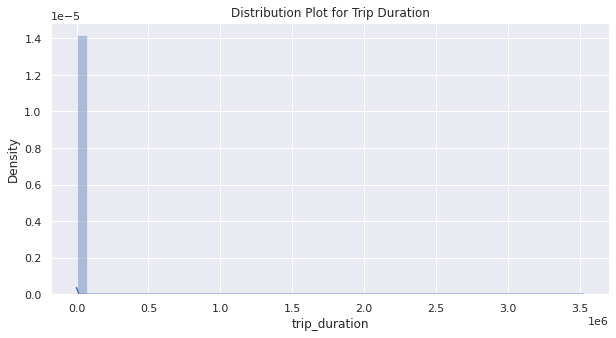

In [23]:
#Dependent variable 'trip_duration'
plt.figure(figsize=(10,5))
sns.distplot(nyc_df['trip_duration'],color="b").set(title='Distribution Plot for Trip Duration')

[Text(0.5, 1.0, 'Distribution Plot with Log Transformation for Trip Duration')]

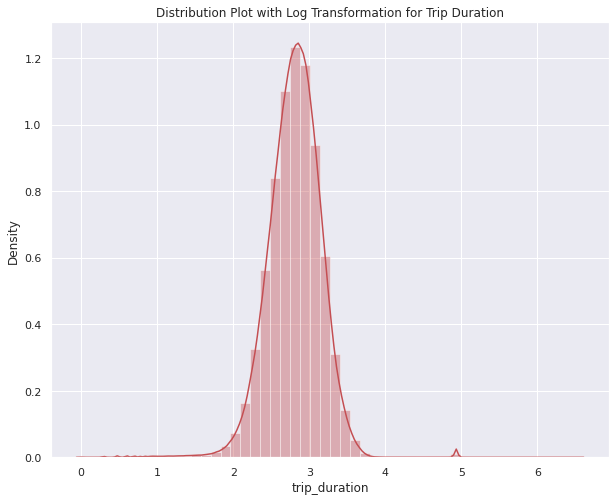

In [24]:
plt.figure(figsize=(10,8))
sns.distplot(np.log10(nyc_df['trip_duration']),color="R").set(title='Distribution Plot with Log Transformation for Trip Duration')

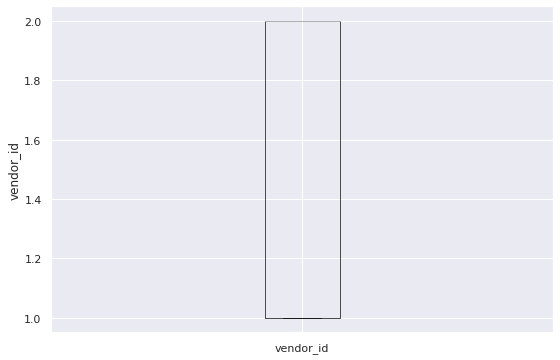

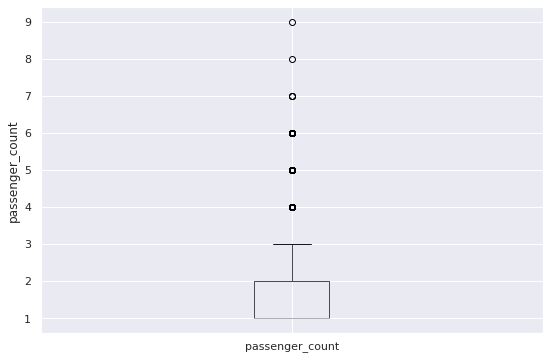

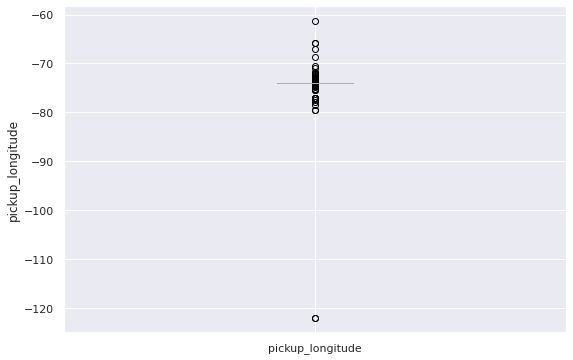

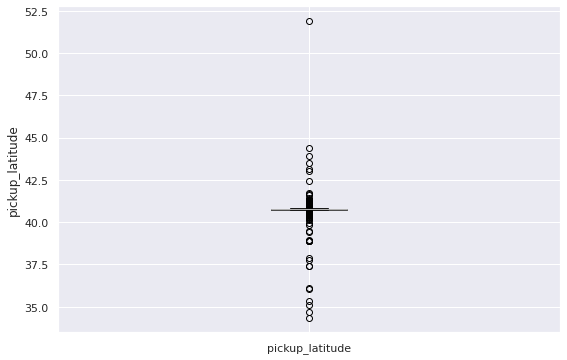

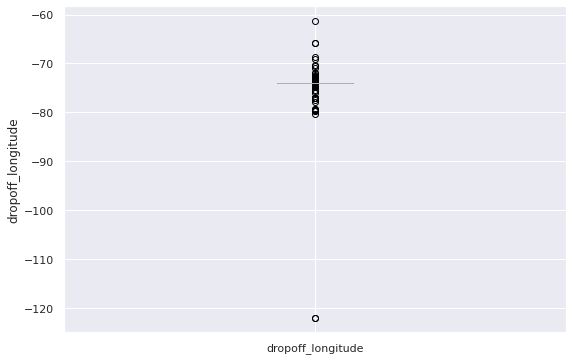

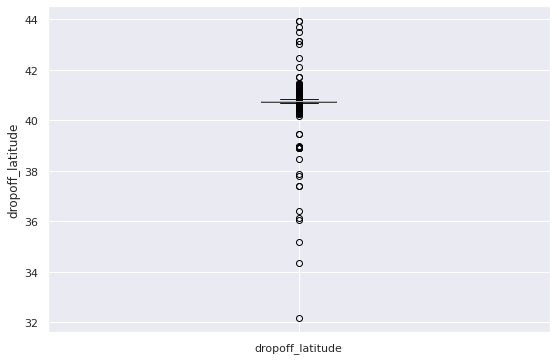

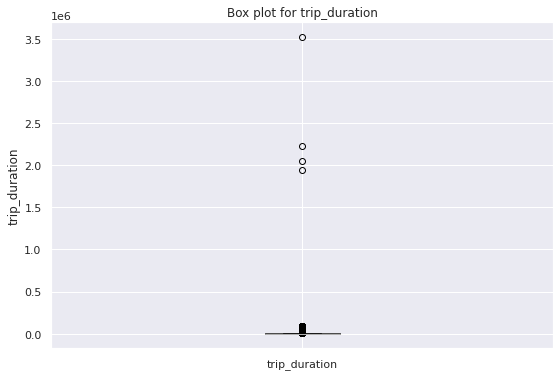

In [25]:
# plot a boxplot for the label by each numerical feature  
for col in nyc_df.describe().columns:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  nyc_df.boxplot(column = col, ax = ax)
  ax.set_ylabel(col)
plt.title("Box plot for trip_duration")
plt.show()

Vendor ID has no outlier.

In passenger count 4 and more passengers are being treated as outliers.

pickup_longitude and pickup_latitude has outliers as well.

dropoff_longitude and dropoff_latitude has outliers too.

Our target variable trip_duration has alot of outliers

Checking consitency of trip_duration

from the box plot we see that there are few outlier having very large value. we have to remove those outlier. but first let check the consitency of feature "trip duration". To do so we calculate the difference between pick and dropoff time.

In [26]:
# creating a function that will out trip duration from pick and dropoff time
def calculate_trip_duration(pickup,dropoff):
    return (dropoff-pickup).total_seconds()

In [27]:
# creating a feature which stores this calculated trip duration
nyc_df['calculate_trip_duration']=nyc_df.apply(lambda x: calculate_trip_duration(x['pickup_datetime'],x['dropoff_datetime']),axis=1)

In [28]:
# checking for consistency by comparing trip duration with calculated trip duration
(nyc_df['calculate_trip_duration']==nyc_df['trip_duration']).value_counts()

True    1458584
dtype: int64

Here, we see that there the trip duration is consistent with the calculated trip duration. so, this large value are purely an outlier.

In [29]:
# Dropping the feature created 
nyc_df.drop(['calculate_trip_duration'],axis=1,inplace=True)

To checked for outlier we segregate our dependent variable into different categories i.e trip whose duration is less then 1min, within 10mins,within hour,within day, within two day and more than two day

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

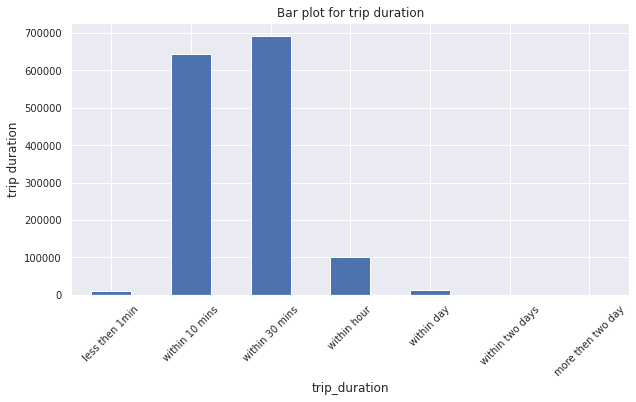

In [30]:
# segregrating the dependent variable into different categories.
plt.figure(figsize=[10,5])
labels=['less then 1min','within 10 mins','within 30 mins','within hour','within day','within two days','more then two day']
nyc_df.groupby(pd.cut(nyc_df['trip_duration'],bins=[0,60,600,1800,3600,86400,86400*2,10000000],labels=labels))['trip_duration'].count().plot(kind='bar',fontsize=10)
plt.title("Bar plot for trip duration")
plt.ylabel("trip counts")
plt.ylabel("trip duration")
plt.xticks(rotation=45)

In [31]:
numeric_features = nyc_df.describe().columns
numeric_features

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration'],
      dtype='object')

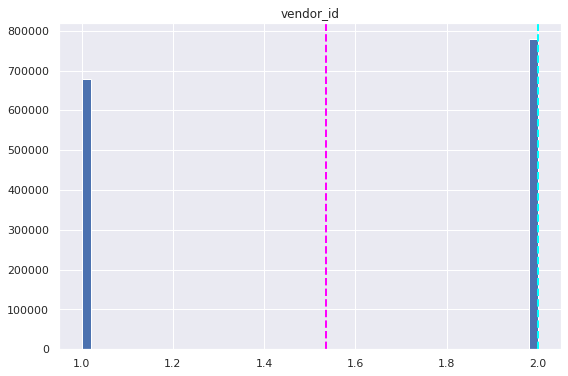

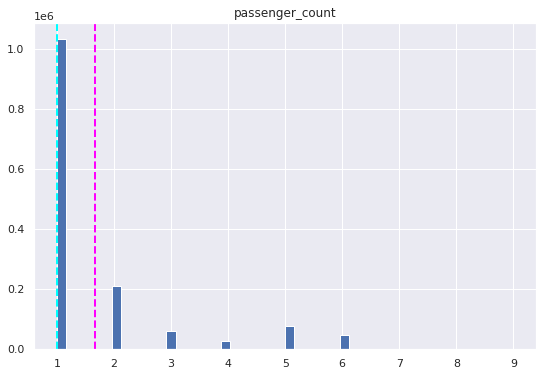

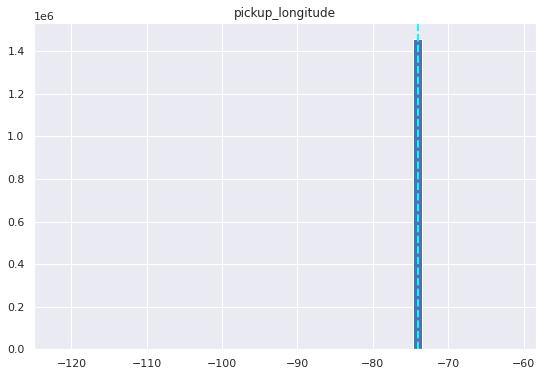

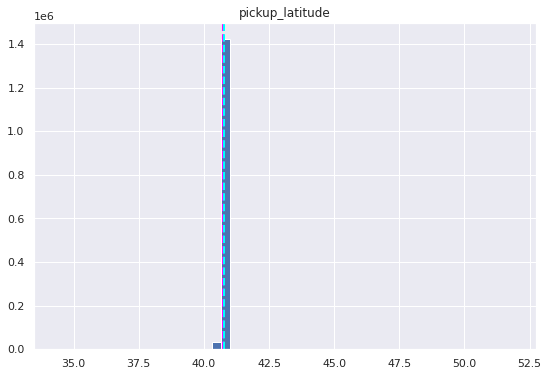

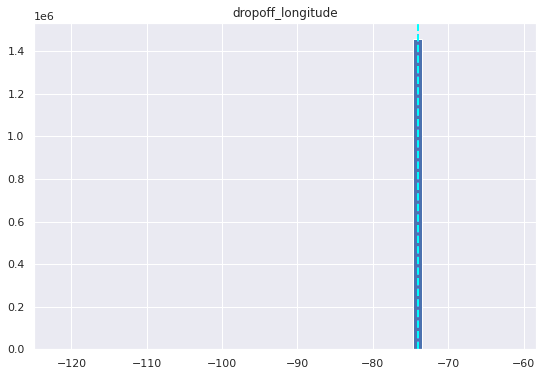

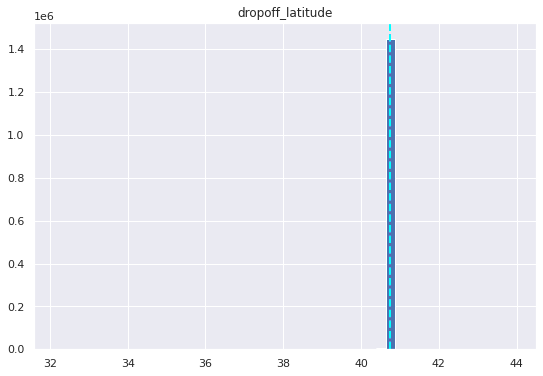

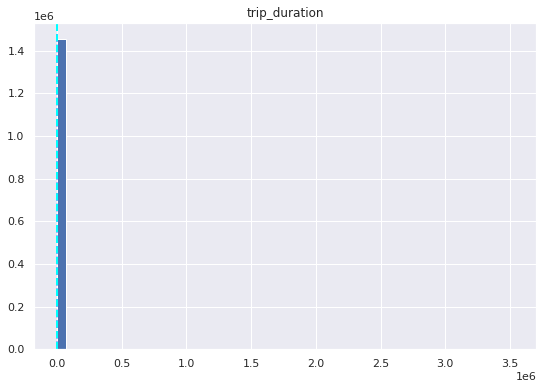

In [32]:
# plot a bar plot for each numerical feature count
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = nyc_df[col]
    feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()